In [144]:
import shelve
import os
import torch
import warnings
import random
from torch.utils.data import Dataset

In [145]:
os.chdir('/Users/rraj/PythonFunctions/DCNet/')
os.getcwd()

'/Users/rraj/PythonFunctions/DCNet'

In [90]:
class ModelData:
    def read_data(self, data_identifier: str, data_type: str):
        file_path = self.check_identifier(data_identifier)
        
        f = shelve.open(file_path[:-3], 'r')
        if data_type == 'train':
            data = f['train_dict']
        elif data_type == 'test':
            data = f['train_dict']
        else:
            raise Exception("invalid data type requested")
        f.close()
        return data
    
    def check_identifier(self, data_identifier: str):
        file_path = data_identifier
        if 'Data' not in data_identifier:
            file_path = os.path.join(os.getcwd(), 'Data', 'Data-'+data_identifier+'.db')
        
        if not os.path.isfile(file_path):
            raise FileNotFoundError(f"{file_path} not found")
        else:
            return file_path
        
        
    def labels_to_index_dict(self, data: dict):
        return {label : indx for indx, label in enumerate(data.keys())}
    
    def index_to_labels_dict(self, labels_to_index_dict: dict):
        return {indx : label for label, indx in labels_to_index_dict.items()}
    
    def get_nclasses(self, data: dict):
        return len(data.keys())
    
    def get_sample_sizes(self, data: dict, index_to_label_dict: dict):
        sample_sizes = []
        for indx in range(len(data)):
            label = index_to_label_dict.get(indx, None)
            sample_sizes.append(data[label].shape[1])
        return sample_sizes

    def get_max_batch_size(self, sample_sizes: list):
        return min(sample_sizes)*len(sample_sizes)
    
    def get_max_data_dim(self, data: dict):
        data_dims = [values.shape[0] for values in data.values()]
        return max(data_dims)


    

In [91]:
class TrainData(ModelData, Dataset):
    def __init__(self, data_identifier: str):
        self.data = self.read_data(data_identifier, 'train')
        self.nclasses = self.get_nclasses(self.data)
        self.labels_to_index = self.labels_to_index_dict(self.data)
        self.index_to_labels = self.index_to_labels_dict(self.labels_to_index)
        self.sample_sizes = self.get_sample_sizes(self.data, self.index_to_labels)
        self.max_batch_size = self.get_max_batch_size(self.sample_sizes)
        

    def __len__(self):
        total_samples = 0
        for value in self.data.values():
            total_samples += value.shape[1]
        return total_samples
    
    def __getitem__(self, index):
        if isinstance(index, tuple) and len(index) == 2:
            k = self.index_to_labels.get(index[0], None)
            return torch.unsqueeze(torch.from_numpy(self.data[k][:, index[1]]), 0)
        else:
            raise IndexError(f"{index} not supported")
        
    def get_data_dim(self):
        return self.get_max_data_dim(self.data)

In [92]:
class TestData(ModelData, Dataset):
    def __init__(self, data_identifier: str):
        self.data = self.read_data(data_identifier, 'test')
        self.labels_to_index = self.labels_to_index_dict(self.data)
        self.nclasses = self.get_nclasses(self.data)
        self.index_to_labels = self.index_to_labels_dict(self.labels_to_index)
        self.sample_sizes = self.get_sample_sizes(self.data, self.index_to_labels)

    def __len__(self):
        total_samples = 0
        for value in self.data.values():
            total_samples += value.shape[1]
        return total_samples
    
    def __getitem__(self, index):
        if isinstance(index, tuple) and len(index) == 2:
            k = self.index_to_labels.get(index[0], None)
            return torch.unsqueeze(torch.from_numpy(self.data[k][:, index[1]]), 0)
        else:
            raise IndexError(f"{index} not supported")
        
    def get_data_dim(self):
        return self.get_max_data_dim(self.data)
        

In [93]:
class TrainLoader:
    def __init__(self, data_source, batch_size: int = 0, n_iter: int = 1, shuffle: bool = False):
        self.data_source = data_source
        self.n_iter = n_iter
        self.shuffle = shuffle
        self.returned_index = 0
        self.adjusted_batch_size = self.adjust_batch_size(batch_size)
        self.nsamples = self.get_nsamples()
        self.class_indices_r = self.get_randomized_class_indices()
        self.sample_indices_r = self.get_randomized_sample_indices()
        
    def __iter__(self):
        return self
    
    def __next__(self):
        if self.n_iter > 0 and self.returned_index < self.adjusted_batch_size:
            c_indx, s_indx = divmod(self.returned_index, self.nsamples)
            self.returned_index += 1
            self.update_batch()
            if self.shuffle:
                indx = self.class_indices_r[c_indx], random.randrange(self.data_source.sample_sizes[c_indx])
                return self.data_source[indx]
            else:
                indx = self.class_indices_r[c_indx], (self.sample_indices_r[c_indx] + s_indx)
                return self.data_source[indx]
        else:
            raise StopIteration

    def update_batch(self):
        if self.returned_index == self.adjusted_batch_size:
            self.n_iter -= 1
            random.shuffle(self.class_indices_r)
            self.sample_indices_r = self.get_randomized_sample_indices()
            self.returned_index = 0
        
    def adjust_batch_size(self, batch_size: int):
        adjusted_batch_size = min(max(batch_size//self.data_source.nclasses, 1) * self.data_source.nclasses, self.data_source.max_batch_size)
        if adjusted_batch_size != batch_size:
            warnings.warn(f"batch size adjusted to {adjusted_batch_size}")
        return adjusted_batch_size

    def get_nsamples(self):
        return (self.adjusted_batch_size//self.data_source.nclasses)
    
    def get_randomized_class_indices(self):
        class_indices_r = [*range(self.data_source.nclasses)]
        random.shuffle(class_indices_r)
        return class_indices_r
    
    def get_randomized_sample_indices(self):
        sample_indices_r = []
        for indx in self.class_indices_r:
            random_start_limit = self.data_source.sample_sizes[indx] - self.nsamples
            sample_indices_r.append(random.randint(0, random_start_limit))
        return sample_indices_r
    
    def get_batch_size(self):
        return self.adjusted_batch_size

In [94]:
class TestLoader:
    def __init__(self, data_source):
        self.data_source = data_source
        self.returned_class_indx = 0
        self.returned_sample_indx = 0

    def __iter__(self):
        return self
    
    def __next__(self):
        if self.returned_class_indx < self.data_source.nclasses and self.returned_sample_indx < self.data_source.sample_sizes[self.returned_class_indx]:
            indx = self.returned_class_indx, self.returned_sample_indx
            self.returned_sample_indx += 1
            self.update_class()
            return self.data_source[indx]
        else:
            raise StopIteration
    
    def update_class(self):
        if self.returned_sample_indx == self.data_source.sample_sizes[self.returned_class_indx]:
            self.returned_class_indx += 1
            self.returned_sample_indx = 0

    def get_index_to_class_dict(self):
        return self.data_source.index_to_labels
    
    def get_class_to_index_dict(self):
        return self.data_source.labels_to_index

In [10]:
train_inputs = TrainData('May04-2357')
train_loader = TrainLoader(train_inputs, batch_size=128, n_iter=2)
test_inputs = TestData('May04-2357')
test_loader = TestLoader(test_inputs)

In [3]:
import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.DEBUG)
logging.debug('This message should appear on the console')
logging.info('So should this')
logging.warning('And this, too')

DEBUG:This message should appear on the console
INFO:So should this


In [399]:
import torch
from torch.nn.functional import normalize
from torch.linalg import multi_dot

def get_init_batch(train_inputs: TrainData, n_batches: int=1):
    data_dim = train_inputs.get_data_dim()
    batch_size = int(0.25*len(train_inputs))
    train_loader = TrainLoader(train_inputs, batch_size=batch_size, n_iter=n_batches)
    adjusted_batch_size = train_loader.get_batch_size()
    init_tensor = torch.empty((n_batches, adjusted_batch_size, data_dim))
    for i, input in enumerate(train_loader):
        batch_number, sample_number = divmod(i, adjusted_batch_size)
        init_tensor[batch_number, sample_number, :] = torch.flatten(input, start_dim=0)
    return init_tensor

def get_effective_dim(S: torch.Tensor):
    assert S.dim() == 1, "singular values must be in 1D vector"
    S_n = S**2/torch.sum(S**2)
    n_comp = 0
    for i in range(len(S_n)):
        if torch.sum(S_n[:i]) > 0.95:
            n_comp = i+1
            break
    return n_comp

def randomizer_matrix(m: int, n: int):
    assert m >= n, f"m={m} should be greater than or equal to n={n}"
    _, _, V = torch.pca_lowrank(torch.rand(n, n), q=n)
    if m > n:
        random_matrix = normalize(torch.randn(m-n, n), p=2, dim=1)
        Vc = torch.mm(random_matrix, V)
        return torch.vstack((V, Vc))
    else:
        return V

def input_svd_matrices(init_batch: torch.Tensor):
    _, S, V = torch.pca_lowrank(init_batch)
    effective_dim = get_effective_dim(S)
    return V[:, :effective_dim], S[:effective_dim], effective_dim

def initialize_network_connections(layer_dims: list, data_identifier: str):
    train_inputs = TrainData(data_identifier)
    init_batch = get_init_batch(train_inputs)
    left_matrix, sigma, n = input_svd_matrices(init_batch)
    sigma_r = sigma**(-1/len(layer_dims))
    
    for dim in layer_dims:
        right_matrix = randomizer_matrix(layer_dims[dim], n)
        w = multi_dot([left_matrix, torch.diag(sigma_r), right_matrix.T])
        w_n = normalize(w, p=2.0, dim=1)
        left_matrix = right_matrix
    return None


NameError: name 'TrainData' is not defined

In [96]:
train_inputs = TrainData('May04-2357')
init_tensor = get_init_batch(train_inputs, n_batches=3)
print(init_tensor.shape)

torch.Size([3, 64, 102])


/var/folders/b9/8km7dn7s35bfc4y81hgxnfj9d52_hx/T/ipykernel_43991/2289762838.py:39: UserWarning: batch size adjusted to 64
  warnings.warn(f"batch size adjusted to {adjusted_batch_size}")


In [163]:
from torch import nn

class Hash(nn.Module):
    def __init__(self, input_size: int, hash_length: int):
        super().__init__()
        self.fc = nn.Linear(input_size, hash_length, bias=False)
        self.activation = nn.ReLU()

    def forward(self, x: torch.Tensor):
        assert x.dim() == 3
        out = self.fc(x)
        out = self.activation(out)
        return self.hash_function(torch.sign(out))
    
    def hash_function(self, out: torch.Tensor):
        out_f = torch.flatten(out, end_dim=1)
        hash_values = torch.empty((out_f.shape[0], 1))
        for indx, row in enumerate(out_f):
            hash_values[indx, 0] = sum(v*2**i for i, v in enumerate(reversed(row)))
        return hash_values.reshape(*out.shape[:-1], 1)


class MultiHash(nn.Module):
    def __init__(self, input_size: int, n_heads: int):
        super().__init__()
        self.n_heads = n_heads
        self.input_size = input_size
        self.hash_length = 2*input_size #find optimal number of partitions
    
    def forward(self, x: torch.Tensor):
        hash_tensor = torch.empty((*x.shape[:-1], self.n_heads))
        for head in range(self.n_heads):
            hash_layer = Hash(self.input_size, self.hash_length)
            hash_tensor[:, :, head] = torch.flatten(hash_layer(x), start_dim=1)
        return hash_tensor

    


# implement to get input indices or make sure that at max bach size inputs are generated orederly

In [164]:
a1 = torch.tensor([[[1, 2, 3, 4]]], dtype=torch.float)
a2 = torch.tensor([[[1, 1, 1, 1],[5, 6, 7, 8], [0, 0, 0, 0], [6, 4, 5, 2], [7, 3, 9, 1]]], dtype=torch.float)
a3 = torch.vstack((a2, a2)).reshape(2, 5, 4)

print('------input tensor shapes-----')
print(a1.shape)
print(a2.shape)
print(a3.shape)

hash_layer = Hash(4, 3)

print('------output tensor shapes-----')
print(hash_layer(a1).shape)
print(hash_layer(a2).shape)
print(hash_layer(a3).shape)

hash_pool = MultiHash(4, 3)

print('------hashpool tensor shapes-----')
print(hash_pool(a1).shape)
print(hash_pool(a2).shape)
print(hash_pool(a3).shape)

------input tensor shapes-----
torch.Size([1, 1, 4])
torch.Size([1, 5, 4])
torch.Size([2, 5, 4])
------output tensor shapes-----
torch.Size([1, 1, 1])
torch.Size([1, 5, 1])
torch.Size([2, 5, 1])
------hashpool tensor shapes-----
torch.Size([1, 1, 3])
torch.Size([1, 5, 3])
torch.Size([2, 5, 3])


In [71]:
print(hash_pool(a1))
print("------**------")
print(hash_pool(a2))
print("------**------")
print(hash_pool(a3))


tensor([[[180., 118.,  49.]]], grad_fn=<CopySlices>)
------**------
tensor([[[203.,  73., 212.],
         [203., 129., 214.],
         [  0.,   0.,   0.],
         [203., 217., 179.],
         [203., 155., 215.]]], grad_fn=<CopySlices>)
------**------
tensor([[[ 97., 192., 124.],
         [ 97., 192., 124.],
         [  0.,   0.,   0.],
         [101., 130., 220.],
         [100., 130., 216.]],

        [[ 97., 192., 124.],
         [ 97., 192., 124.],
         [  0.,   0.,   0.],
         [101., 130., 220.],
         [100., 130., 216.]]], grad_fn=<CopySlices>)


In [22]:
inp = torch.rand(1, 2, 3)
torch.flatten(inp, end_dim=1)

tensor([[0.6269, 0.9706, 0.4694],
        [0.7349, 0.6549, 0.6819]])

In [203]:
from torch import nn
from torch.nn.functional import normalize

class ModuleD(nn.Module):
    def __init__(self, W: torch.Tensor, w_lateral: torch.Tensor = torch.empty((0,0)), mode: str='l'):
        super().__init__()
        assert W.dim() == 2, "weight must be a 2D tensor"
        self.mode = mode
        self.w = W
        self.w_lateral = self.set_recurrent_weights(w_lateral)
        self.activation = nn.ReLU()
        
    
    def forward(self, x: torch.Tensor):
        out_ = torch.mm(x, self.w)
        out_ = self.approximate_recurrence(out_)
        out_f = self.activation(out_)
        self.update_forward_weights(x, out_f) if self.mode == 'l' else None
        return out_f

    def approximate_recurrence(self, s: torch.Tensor):
        # check shape constraints
        assert s.dim() == 2 and s.shape[0] == 1, "intermediate response must be a row vector"
        assert self.w_lateral.dim() == 2, "connectivity matrix must be 2D"
        assert self.w_lateral.shape[0] == self.w_lateral.shape[1] == s.shape[1], "recurrent connections must be all to all"
        
        # flatten response and approximate recurrence
        m = s.shape[1]
        s_flatten = torch.flatten(s, start_dim=0)
        selection_diag = self.estimate_support(s_flatten)
        A_m = torch.eye(m) + torch.mm(torch.diag(selection_diag), self.w_lateral) -   torch.diag(selection_diag)
        return torch.mm(s, torch.inverse(A_m))
    
    def estimate_support(self, s_flatten: torch.Tensor):
        # check shape constrains and initialize selection variables
        assert s_flatten.dim() == 1, "response must be passed as a vector"
        n, m = self.w.shape
        selection_diag = torch.zeros(m)
        selection_indx = torch.argsort(s_flatten, descending=True)
        
        # if dimension expansion performa binary search
        if m > n:
            left, mid, right = 0, int(0.5*(m-1)), m-1
            while left < right:
                selection_diag[selection_indx[:mid]] = 1
                A_m = torch.eye(m) + torch.mm(torch.diag(selection_diag), self.w_lateral) - torch.diag(selection_diag)
                r = torch.linalg.matrix_rank(A_m)
                #print(left, " ", mid, " ", right)
                if r < m:
                    right = mid-1
                else:
                    left = mid+1
                mid = int(0.5*(left+right))
                selection_diag = torch.zeros(m)
                if mid == left or mid == right:
                    break
            selection_diag[selection_indx[:mid]] = 1
        # else select top n values
        else:
            selection_diag[selection_indx[:m]] = 1
        return selection_diag

    
    def set_recurrent_weights(self, w_lateral: torch.Tensor):
        recurrent_weights = w_lateral if w_lateral.numel() else torch.mm(self.w.T, self.w)
        return recurrent_weights

    def update_forward_weights(self, x: torch.Tensor, y: torch.Tensor):
        pass

    def get_forward_weights(self):
        return self.w
    
    def turn_grads_off(self):
        pass

In [147]:
from torch.nn.functional import normalize

def get_sparse_inputs(m: int, s: float):
    y = torch.zeros(1, m)
    ind = torch.randint(0, m, (int(m*s),))
    y[0, ind] = 1
    return y

def compare_vecs(y: torch.Tensor, y_0: torch.Tensor, n: int):
    assert y.shape == y_0.shape
    m = y.shape[1]
    smx = nn.Softmax(dim=1)
    y_0_s = smx(y_0)
    y_0_n = torch.zeros(1, m)
    y_0_f = torch.flatten(y_0_s, start_dim=0)
    #ind_guess = torch.argsort(y_0_f, descending=True)
    ind_guess = y_0_f > 1/m
    y_0_n[0, ind_guess] = 1
    return torch.mm(y_0_n, y.T)/torch.sum(y)

def init_wights(n: int, m: int, s: float):
    w = torch.empty(1, m)
    for _ in range(n):
        w = torch.vstack((w, get_sparse_inputs(m, s)))
    w = w[1:,:]
    w_n = normalize(w, p=2, dim=0)
    return w_n

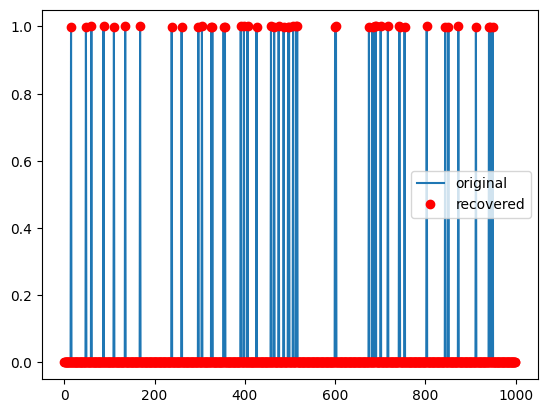

In [211]:
# sample run
from matplotlib import pyplot as plt

n, m, s = 500, 1000, 0.05
w = torch.randn(n, m)
w_n = normalize(w, p=2, dim=0)
y = get_sparse_inputs(m, s)
x = torch.mm(y, w_n.T)
l = ModuleD(w_n)
y_hat = l(x)


plt.plot(y[0,:].numpy(), label='original')
plt.plot(y_hat[0,:].numpy(), 'o', color='r', label='recovered')
plt.legend()

In [262]:
import time
E = torch.zeros(4, 4, 5)
t_elapsed = torch.zeros(4, 4)

for i, n in enumerate([100, 200, 500, 1000]):
    print(n, end=" ")
    for j, m in enumerate([100, 200, 500, 1000]):
        start = time.time()
        for k, sp in enumerate([1, 2, 3, 5, 10]):
            s = 0.01*sp
            for _ in range(100):
                W = torch.randn(n, m)
                W_n = normalize(W, p=2, dim=0)
                y = torch.zeros(1, m)
                ind = torch.randint(0, m, (int(m*s),))
                y[0, ind] = 1
                x = torch.mm(y, W_n.T)
                layer = ModuleD(W_n)
                y_hat = layer(x)
                y_0 = torch.mm(x, W_n)
                E[i, j, k] += torch.flatten(torch.mm(y, y_hat.T), start_dim=0)[0]/(torch.norm(y, p='fro')*torch.norm(y_hat, p='fro'))
        t_elapsed[i, j] = time.time()-start


100 200 500 1000 

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])


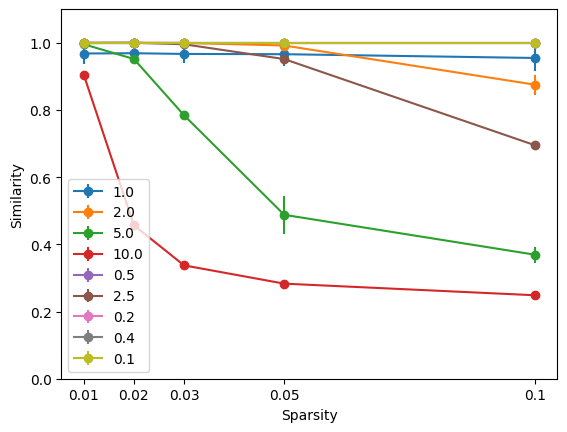

In [263]:
ErrorDict = {}
for i, n in enumerate([100, 200, 500, 1000]):
    for j, m in enumerate([100, 200, 500, 1000]):
        ratio = m/n
        ErrorDict[ratio] = torch.vstack((ErrorDict.get(ratio, torch.empty(1, 5)), E[i, j, :]))

for k, v in ErrorDict.items():
    y_err = 0.01*torch.std(v[1:,:], dim=0)
    plt.errorbar([1, 2, 3, 5, 10], 0.01*torch.mean(v[1:,:], dim=0), label=str(k), yerr = y_err, marker='o')

plt.xticks([1, 2, 3, 5, 10], [0.01, 0.02, 0.03, 0.05, 0.1])
plt.ylim(0, 1.1)
plt.xlabel("Sparsity")
plt.ylabel("Similarity")
plt.legend()

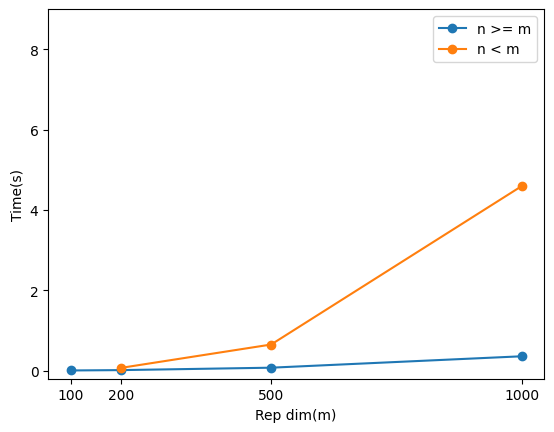

In [272]:
x = torch.zeros(4, 2)
c = torch.zeros(4, 2)
for j, m in enumerate([100, 200, 500, 1000]):
    for i, n in enumerate([100, 200, 500, 1000]):
        if m > n:
            x[j,1] += t_elapsed[i,j]
            c[j,1] += 100
        else:
            x[j,0] += t_elapsed[i,j]
            c[j,0] += 100

x = x/c

plt.plot([1, 2, 5, 10], x[:, 0], marker='o', label='n >= m')
plt.plot([2, 5, 10], x[1:, 1], marker='o', label='n < m')
plt.xticks([1, 2, 5, 10], [100, 200, 500, 1000])
plt.xlabel('Rep dim(m)')
plt.ylabel('Time(s)')
plt.ylim(-0.2, 9)
plt.legend()

In [288]:
# vanilla RNN
def vRNN(x: torch.Tensor, w: torch.Tensor):
    n, m = w.shape
    w_l = torch.mm(w.T, w)
    inpt = torch.mm(x, w)
    y = torch.zeros(1, m)
    a = torch.zeros(1, m)
    threshold = nn.ReLU()

    for _ in range(500):
        rec = torch.mm(a, w_l - torch.eye(m))
        dy = 0.01*(inpt - y - rec)
        y += dy
        a = threshold(y)
        if torch.norm(dy) < 0.0001:
            break
    return a

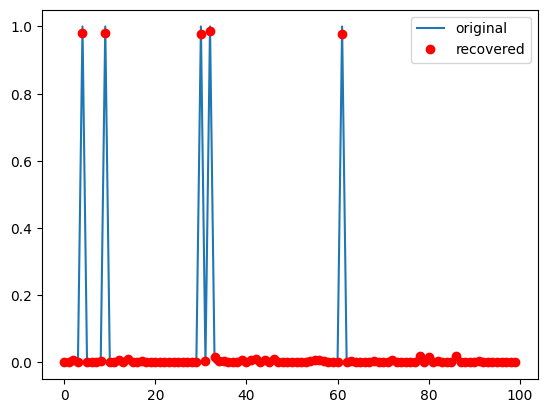

In [289]:
n, m, s = 500, 100, 0.05
w = torch.randn(n, m)
w_n = normalize(w, p=2, dim=0)
y = get_sparse_inputs(m, s)
x = torch.mm(y, w_n.T)

y_hat = vRNN(x, w_n)


plt.plot(y[0,:].numpy(), label='original')
plt.plot(y_hat[0,:].numpy(), 'o', color='r', label='recovered')
plt.legend()

In [290]:
import time
E = torch.zeros(4, 4, 5)
t_elapsed = torch.zeros(4, 4)

for i, n in enumerate([100, 200, 500, 1000]):
    print(n, end=" ")
    for j, m in enumerate([100, 200, 500, 1000]):
        start = time.time()
        for k, sp in enumerate([1, 2, 3, 5, 10]):
            s = 0.01*sp
            for _ in range(100):
                W = torch.randn(n, m)
                W_n = normalize(W, p=2, dim=0)
                y = torch.zeros(1, m)
                ind = torch.randint(0, m, (int(m*s),))
                y[0, ind] = 1
                x = torch.mm(y, W_n.T)
                y_hat = vRNN(x, W_n)
                y_0 = torch.mm(x, W_n)
                E[i, j, k] += torch.flatten(torch.mm(y, y_hat.T), start_dim=0)[0]/(torch.norm(y, p='fro')*torch.norm(y_hat, p='fro'))
        t_elapsed[i, j] = time.time()-start

100 200 500 1000 

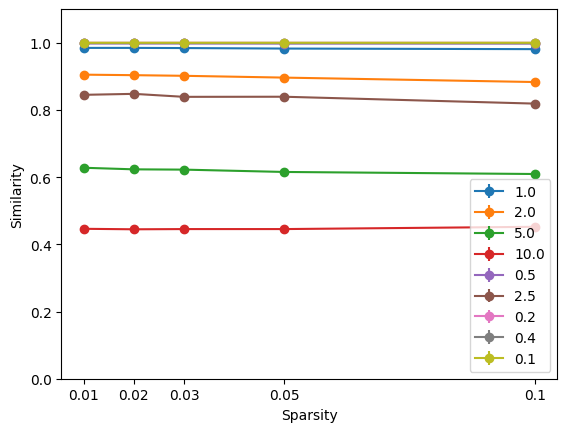

In [291]:
ErrorDict = {}
for i, n in enumerate([100, 200, 500, 1000]):
    for j, m in enumerate([100, 200, 500, 1000]):
        ratio = m/n
        ErrorDict[ratio] = torch.vstack((ErrorDict.get(ratio, torch.empty(1, 5)), E[i, j, :]))

for k, v in ErrorDict.items():
    y_err = 0.01*torch.std(v[1:,:], dim=0)
    plt.errorbar([1, 2, 3, 5, 10], 0.01*torch.mean(v[1:,:], dim=0), label=str(k), yerr = y_err, marker='o')

plt.xticks([1, 2, 3, 5, 10], [0.01, 0.02, 0.03, 0.05, 0.1])
plt.ylim(0, 1.1)
plt.xlabel("Sparsity")
plt.ylabel("Similarity")
plt.legend()

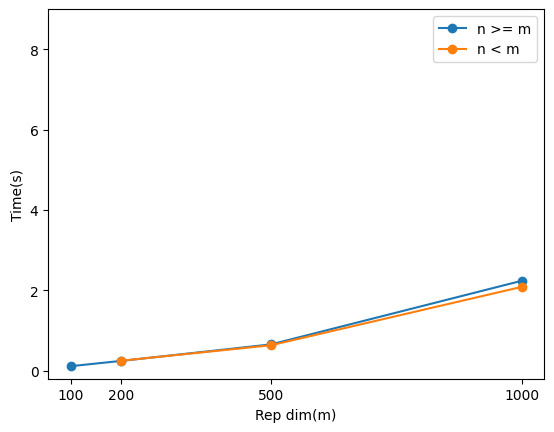

In [292]:
x = torch.zeros(4, 2)
c = torch.zeros(4, 2)
for j, m in enumerate([100, 200, 500, 1000]):
    for i, n in enumerate([100, 200, 500, 1000]):
        if m > n:
            x[j,1] += t_elapsed[i,j]
            c[j,1] += 100
        else:
            x[j,0] += t_elapsed[i,j]
            c[j,0] += 100

x = x/c

plt.plot([1, 2, 5, 10], x[:, 0], marker='o', label='n >= m')
plt.plot([2, 5, 10], x[1:, 1], marker='o', label='n < m')
plt.xticks([1, 2, 5, 10], [100, 200, 500, 1000])
plt.xlabel('Rep dim(m)')
plt.ylabel('Time(s)')
plt.ylim(-0.2, 9)
plt.legend()

In [ ]:
import torch
from torch import nn
from torch.linalg import matrix_rank, multi_dot

class Feedforward(nn.Module):
    def __init__(self, weights: torch.Tensor):
        super().__init__()
        assert weights.dim() == 2, "connectivity matrix must be 2D"
        self.weights = weights
        self.expansion = weights.shape[0] < weights.shape[1]

    def forward(self, input: torch.Tensor):
        return torch.mm(input, self.weights)
    
    def update_weights(self, x: torch.Tensor, y: torch.Tensor, lr: float = 0.001):
        norm_y = torch.norm(y, p='fro').item()
        dw = lr*(torch.mm(x.T, y) - (torch.linalg.multi_dot((self.weights, y.T, y))/norm_y))
        self.weights += dw
    


class Recurrent(nn.Module):
    def __init__(self, weights: torch.Tensor, expansion: bool=False):
        super().__init__()
        assert weights.dim() == 2 and self.weights.shape[0] == self.weights.shape[1], "recurrent connections must be all to all and 2D"
        self.weights = weights
        self.expansion = expansion

    def forward(self, input: torch.Tensor):
        approx_recurrence = self.approximate_recurrence(input)
        return torch.mm(input, approx_recurrence)
    
    def approximate_recurrence(self, input: torch.Tensor):
        # check shape constrains and initialize selection variables
        m = input.shape[1]
        selection_diag = torch.zeros(m)
        selection_indx = torch.flatten(torch.argsort(input, descending=True), start_dim=0)
        
        # if dimension expansion perform a binary search
        if self.expansion:
            left, right = 0, m-1
            while left < right:
                mid = int(0.5*(left+right))
                selection_diag[selection_indx[:mid]] = 1 
                if mid == left or mid == right:
                    break    
                
                sys_mat = self.system_matrix(selection_diag)
                if matrix_rank(sys_mat) < m:
                    right = mid-1
                else:
                    left = mid+1  
                
                selection_diag[torch.nonzero(selection_diag)] = 0
            
        # else select top m values
        else:
            selection_diag[selection_indx[:m]] = 1
        
        # return selection diagonal
        return torch.inverse(self.system_matrix(selection_diag))
    
    def system_matrix(self, selection_diag: torch.Tensor):
        return torch.eye(len(selection_diag)) + torch.mm(torch.diag(selection_diag), self.weights) - torch.diag(selection_diag)
    

class DiscriminationModule(nn.Module):
    def __init__(self, feedforward_weights: torch.Tensor, recurrent_weights: torch.Tensor=torch.empty((0,0)), lr: float=0.001, mode: str='l'):
        super().__init__()
        self.feedforward = Feedforward(feedforward_weights)
        self.recurrent = Recurrent(self.set_recurrent_weights(recurrent_weights), expansion=self.feedforward.expansion)
        self.activation = nn.ReLU()
        self.mode = mode
        self.lr = lr

    def forward(self, input: torch.Tensor):
        assert input.dim() == 2 and input.shape[0] == 1, "input must be a row vector"
        out_ = self.feedforward(input)
        out_ = self.recurrent(out_)
        out_f = self.activation(out_)

        if self.mode == 'l':
            self.feedforward.update_weights(input, out_f) 
        elif self.mode == 'r': 
            return out_f
        else:
            raise ValueError("mode must be 'l' or 'r'")

    def set_recurrent_weights(self, recurrent_weights: torch.Tensor):
        recurrent_weights = recurrent_weights if recurrent_weights.numel() else torch.mm(self.feedforward.weights.T, self.feedforward.weights)
        return recurrent_weights
    
    

In [303]:
if m > n:
            left, mid, right = 0, int(0.5*(m-1)), m-1
            while left < right:
                selection_diag[selection_indx[:mid]] = 1
                A_m = torch.eye(m) + torch.mm(torch.diag(selection_diag), self.w_lateral) - torch.diag(selection_diag)
                r = torch.linalg.matrix_rank(A_m)
                #print(left, " ", mid, " ", right)
                if r < m:
                    right = mid-1
                else:
                    left = mid+1
                mid = int(0.5*(left+right))
                selection_diag = torch.zeros(m)
                if mid == left or mid == right:
                    break
            selection_diag[selection_indx[:mid]] = 1
        # else select top n values
        else:
            selection_diag[selection_indx[:m]] = 1

In [323]:
x = torch.tensor([1, 0, 0, 1, 0])
x[torch.nonzero(x)] = 0
print(x)


tensor([0, 0, 0, 0, 0])
